# Implementation Code for the OCE project with ASOS


### I. Libraries

For the purpose of this project we have created a virtual environment using conda. This jupyter notebook need to be opened directly from anaconda environment jupyter notebook and not from jupyter notebook application, since both are not linked in terms of kernel.

This virtual environment, currently called "oce", will provide the general packages for data science and statistics in Python.

In [1]:
################# Libraries

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools as it

### II. Empirical Bayes method : Definition of the prior

In the following section we are interesting in defining method that will be easy to implement and will give us an estimation of prior empirical. We will test this method on three level of data. 

First a quick implementation on data that generated by ourself in order to obtain a complete verification of our method. 

Then we will use the data base Upworthy to do it. This dataset is interesting since it will enable us to verify our approach on quite real data but still cleaned ones. 

Finally we will implement this method on data of ASOS (to be define). 



#### 1. Randomly generated samples

In [14]:
####### Hyperparameter
tau = 3 # the one to estimate
sigma = 4 # considered known



In [15]:
######## Samples

# Drawn the mean theta
theta = stats.norm.rvs(loc=0, scale=tau, size=1000, random_state=None)
# Note : Very easily limited, the cell bugs for size = 10 000.

# Draw one sample for each theta
Y = stats.multivariate_normal.rvs(mean=theta, cov = sigma**2 )


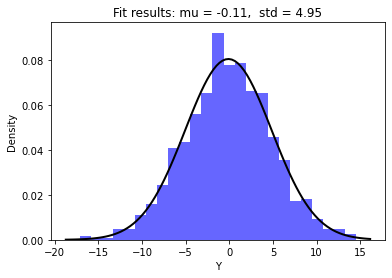

In [21]:
######### Analysis 


# Fit a normal distribution to the data:
mu, std = stats.norm.fit(Y)

# Plot the histogram.
plt.hist(Y, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Y')
plt.ylabel('Density')
plt.show()

In [18]:
estimate_variance_tot = stats.tvar(Y)
print("We obtain a total sample variance of {variance} ".format(variance = estimate_variance_tot))

true_variance_tot = sigma**2 + tau**2

print("The true total variance is {variance} ".format(variance = true_variance_tot))
# They are quite closed.

#Computation of tau considering we know sigma is : 
estimate_tau = np.sqrt(estimate_variance_tot - sigma**2)
print("Tau estimated is {estimate_tau}, quite close for the true value {true_tau}".format(estimate_tau = estimate_tau,
                                                                                  true_tau = tau))


We obtain a total sample variance of 24.5008420475157 
The true total variance is 25 
Tau estimated is 2.915620353803921, quite close for the true value 3


#### 2. Upworthy data set

The Upworthy Research Archive is a dataset of headline A/B tests conducted by Upworthy from early 2013 into April 2015.

In [15]:
# Loading the dataset

dfUpWo = pd.read_csv("data/upworthy-archive-exploratory-packages-03.12.2020.csv")

print(dfUpWo.head())


   Unnamed: 0               created_at               updated_at  \
0           0  2014-11-20 06:43:16.005  2016-04-02 16:33:38.062   
1           1  2014-11-20 06:43:44.646  2016-04-02 16:25:54.021   
2           2  2014-11-20 06:44:59.804  2016-04-02 16:25:54.024   
3           3  2014-11-20 06:54:36.335  2016-04-02 16:25:54.027   
4           4  2014-11-20 06:54:57.878  2016-04-02 16:31:45.671   

       clickability_test_id                           excerpt  \
0  546d88fb84ad38b2ce000024  Things that matter. Pass 'em on.   
1  546d88fb84ad38b2ce000024  Things that matter. Pass 'em on.   
2  546d88fb84ad38b2ce000024  Things that matter. Pass 'em on.   
3  546d902c26714c6c44000039  Things that matter. Pass 'em on.   
4  546d902c26714c6c44000039  Things that matter. Pass 'em on.   

                                            headline  \
0  They're Being Called 'Walmart's Worst Nightmar...   
1  They're Being Called 'Walmart's Worst Nightmar...   
2  They're Being Called 'Walmart's Wor

###### Cleaning the dataset

We want to clean the dataset in order to obtain only one line per version per test
At the beginning there are many lines while displaying the same headline in the same test.
From what we can read here [upworthydataset](https://upworthy.natematias.com/about-the-archive) the only thing that vary between experiment is either the feature "headlines" or the images displayed through the feature "eyecatcher_id". 

However in somes cases, we have supposedly different versions of a test, that have the same headline and images. Two possibilities to handle this case :
-Choice 1 : We consider that it's a bug and only keep one version

-Choice 2 : We aggregate the result as if it was one big test.
The choice 2, could seem tempting. However, we have sometime a result for the test, meaning that they consider them as different versions even if they have the same headline and image.





In [ ]:
# Version 1 : if there are indeed slighlty different we might to keep only one
dfUpWo = dfUpWo.drop_duplicates(subset = ["headline","eyecatcher_id"])



In [ ]:
# Version 2 : if they are exactly the same we want to aggregate them
# [TBD]

In [ ]:
#### New features

# Creating the "clickthrough rate"
dfUpWo["rate"] = dfUpWo["clicks"]/df["impressions"]


#### Problem

Here we are considering mean of binary data. By the CLT it should behave like normal distribution as we wanted. However, in this case we have that the variance of the normal law is strictly defined as the variance of the two binary data divided by n. We have 

\begin{align}
\bar{X}_n - \bar{Y}_n & \sim \mathcal{N}(\theta, V_n/n) \\
V_n & = \bar{X}_n * (1-\bar{X}_n) + \bar{Y}_n*(1-\bar{Y}_n) \\
\end{align}

So this means that given an experiment and so a $\theta$ we obtain variable with different variance in their conditional law. We are not anymore in the framework of an addition of two independent laws. 

Thus, the following already implemented approach is not working

In [ ]:
test_list = dfUpWo["clickability_test_id"]

Zn = []
Vn = []
nsample = []
for i in test_list:
    df_temp = df.loc[df["clickability_test_id"] == i]
    #df_temp = df_temp.drop_duplicates(subset = ["headline"])
    index_temp = df_temp.index
    #df_temp["rate"] = df_temp["clicks"]/df["impressions"]
    rate_list = df_temp["rate"]
    
    # In the following line : if we have only version for this test it will give us a nan,
    # and so won't affect anything since diff_rate_temp and variance_rate_temp will be empty
    iterator = it.combinations(df_temp["rate"], 2)
    click_rate_tuple_temp = [x for x in iterator]
    diff_rate_temp = [x[0]-x[1] for x in click_rate_tuple_temp ]
    variance_rate_temp = [x[0]*(1-x[0]) + x[1]*(1-x[1]) for x in click_rate_tuple_temp ]
    Zn = Zn + diff_rate_temp
    Vn = Vn + variance_rate_temp


In [67]:
# Compute the sigma and the tau of the 

n_mean = np.mean(dfUpWo["impressions"])
sigma2 = (np.mean(np.sqrt(np.asarray(Vn)/2.)))**2
sigma2 = sigma2 / n_mean
Var_tot = stats.tvar(Zn)
tau = np.sqrt(Var_tot-sigma2)


print(Var_tot)
print(sigma2)
print(tau)

3.7014315460269453e-05
3.0702512839197313e-06
0.0058261534631650165


#### 3. New approach : beta binomial

we test here a new approach

(array([0.08286831, 0.28796737, 0.66708988, 0.98095359, 1.37457805,
        1.66461713, 1.76613081, 1.68844177, 1.31864195, 0.52724961]),
 array([0.03119815, 0.12773687, 0.22427558, 0.3208143 , 0.41735302,
        0.51389173, 0.61043045, 0.70696916, 0.80350788, 0.90004659,
        0.99658531]),
 <BarContainer object of 10 artists>)

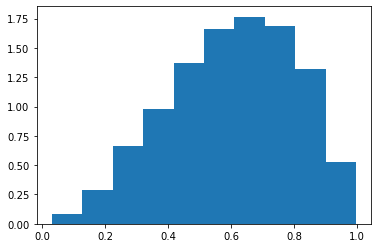

In [6]:
samplesbeta = stats.beta.rvs(3, 2, loc=0, scale=1, size=10000 )

plt.hist(samplesbeta, density="true")

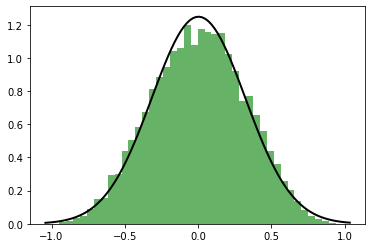

In [19]:
samplesbeta1 = stats.beta.rvs(2, 2, loc=0, scale=1, size=10000 )
samplesbeta2 = stats.beta.rvs(2, 2, loc=0, scale=1, size=10000 )

diff = samplesbeta2 - samplesbeta1

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(diff)

# Plot the histogram.
plt.hist(diff, bins=40, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)


### III. Sequential testing

In this section we are going to implement a sequential test on the grocery dataset. We will pretend knowing the date of each samples (doing a shuffle of the dataset).

Notice : the code has been copied and changed from Tetiana Klimonova work on the Kaggle page of the dataset


##### Description of the data :
- Version of the website : A : Control version with server id 2 and 3 / B : Treatment with server id 1
- Click : binary data VisitFlag : for if they click to check the subscription page
- H0 : theta0 = 0 no differences



In [2]:

##### 1 Read and clean the csv file
dfGrocery = pd.read_csv("data/grocerywebsiteabtestdata.csv")


#Group by IP adress
dfGrocery = dfGrocery.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag'].sum().reset_index(name='sum_VisitPageFlag')
dfGrocery.head()

#Binary variable for 
dfGrocery['visitFlag'] = dfGrocery['sum_VisitPageFlag'].apply(lambda x: 1 if x !=0 else 0)


dfGrocery['group'] = dfGrocery.ServerID.map({1:'Treatment', 2:'Control', 3:'Control'})


print(dfGrocery['visitFlag'].value_counts())

#removing all records where the LoggedInFlag=1, so it filters out all the users with accounts
dfGrocery = dfGrocery[dfGrocery['LoggedInFlag'] != 1]

print(dfGrocery['visitFlag'].value_counts())


dfGrocery.head()



0    89785
1     9978
Name: visitFlag, dtype: int64
0    39535
1     9978
Name: visitFlag, dtype: int64


,IP Address,LoggedInFlag,ServerID,sum_VisitPageFlag,visitFlag,group
0,0.0.108.2,0,1,0,0,Treatment
2,0.0.111.8,0,3,0,0,Control
4,0.0.163.1,0,2,0,0,Control
7,0.0.181.9,0,1,1,1,Treatment
11,0.0.20.3,0,1,0,0,Treatment


In [3]:
# Creating the two database from which we are going to draw sample sequentially
treatment = dfGrocery[dfGrocery['group']=='Treatment']
control = dfGrocery[dfGrocery['group']=='Control']



In [4]:
# Sampling in order to break any dependence and to fake a list of arrival of sample by date
treatment.sample(frac=1)
control.sample(frac=1)

treatment = treatment.reset_index()
control = control.reset_index()

print(treatment.head())



   index IP Address  LoggedInFlag  ServerID  sum_VisitPageFlag  visitFlag  \
0      0  0.0.108.2             0         1                  0          0   
1      7  0.0.181.9             0         1                  1          1   
2     11   0.0.20.3             0         1                  0          0   
3     14  0.0.213.8             0         1                  0          0   
4     16  0.0.220.4             0         1                  1          1   

       group  
0  Treatment  
1  Treatment  
2  Treatment  
3  Treatment  
4  Treatment  


In [5]:
### Settling the parameter of the experiment

# Hypothesis 
theta0 = 0
alpha = 0.05
# Hyper parameter
sigma = 1 # Should be estimated using the intern variance of each version of the website
tau = 1 # Should be estimated using the above section of prior estimation



In [12]:

n1 = treatment.shape[0]
n2 = control.shape[0]

n = min(n1,n2)

stat_n = [1]
p_n = [1]

Xn = []
Xn_mean = []

Yn = []
Yn_mean = []

Zn = []

Vn = []

CImin =[-np.inf]
CImax =[+np.inf]

delta_thetalim = []


for i in range(n):
    j = i + 1
    Xn = Xn + [control["visitFlag"][i]]
    Yn = Yn + [treatment["visitFlag"][i]]
    
    
    Xn_mean = np.mean(Xn)
    Yn_mean = np.mean(Yn)
    
    Zn = Zn + [Yn_mean - Xn_mean]
    
    Vn = Vn + [Xn_mean*(1-Xn_mean) + Yn_mean*(1-Yn_mean)]
    if Vn[-1] == 0 :
        stat_tmp = 1
    else:
        stat_tmp = np.sqrt(Vn[-1]/(Vn[-1]+j*tau**2))* np.exp(((j*tau)**2*(Yn_mean - Xn_mean-theta0)**2)/(2*Vn[-1]*(Vn[-1]+j*tau**2)))
    

    stat_n = stat_n + [stat_tmp]
    
    p_n = p_n + [min(p_n[-1],1/stat_n[-1])]
    
    
    diff_thetalim = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))
    delta_thetalim = delta_thetalim + [diff_thetalim]
    
    CIdiff = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))
    
    CImin_temp = Zn[-1] - CIdiff
    CImax_temp = Zn[-1] + CIdiff
    
    if CImin_temp>CImax[-1] or CImax_temp< CImin[-1]: # Meaning no intersection
        CImax = CImax + [np.nan]
        CImin = CImin + [np.nan]
    
    else : 
        CImax = CImax + [min(CImax[-1],CImax_temp)]
        CImin = CImin + [max(CImin[-1],CImin_temp)]
        
    
    # To monitor the progress
    if i%1000 ==0 :
        print(i)

<ipython-input-12-f0a9e7863a88>:48: RuntimeWarning: divide by zero encountered in double_scalars
  diff_thetalim = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))
<ipython-input-12-f0a9e7863a88>:48: RuntimeWarning: invalid value encountered in double_scalars
  diff_thetalim = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))
<ipython-input-12-f0a9e7863a88>:51: RuntimeWarning: divide by zero encountered in double_scalars
  CIdiff = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))
<ipython-input-12-f0a9e7863a88>:51: RuntimeWarning: invalid value encountered in double_scalars
  CIdiff = np.sqrt(np.abs(np.log(np.sqrt((Vn[-1]+j*tau**2)/Vn[-1]) * (1/alpha)) *(2*Vn[-1]*(Vn[-1]+j*tau**2))/((j*tau)**2)))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


The last p value observed is 0.8108084847624025


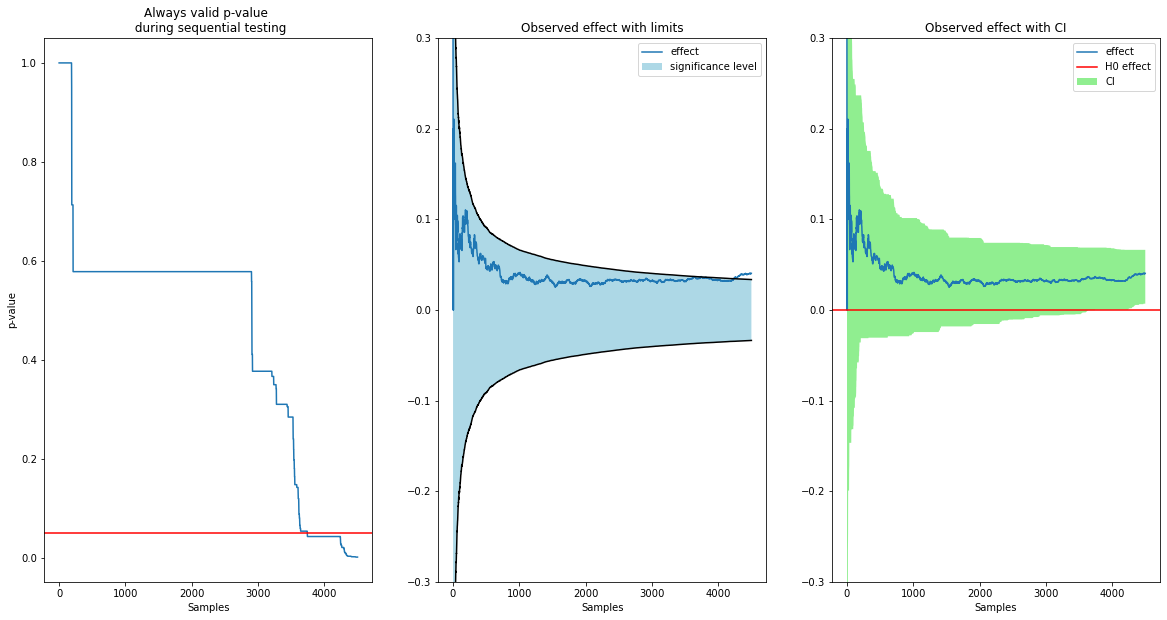

In [21]:

figure, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,10))


##### First plot : p-value
axes[0].plot(p_n[0:4500]) # We diminished the windows
axes[0].axhline(y=0.05, color='r', linestyle='-')
axes[0].set_title("Always valid p-value \n during sequential testing")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("p-value")

last_pvalue = np.min(true_stat)
print("The last p value observed is {pvalue}".format(pvalue = last_pvalue))
# Interesting the author with an A/B test find a significance result while us, using an alpha of 0.05 we didn't. 


##### Second plot : Observed size effect, and significant interval
nwindow = 4500

thetamax = theta0 + np.asarray(delta_thetalim)
thetamin = theta0 - np.asarray(delta_thetalim)
x = np.arange(0, n, 1)

axes[1].plot(Zn[1:nwindow],label="effect") # We diminished the windows
axes[1].plot(x[1:nwindow], thetamin[1:nwindow],x[1:nwindow], thetamax[1:nwindow],color='black')
axes[1].fill_between(x[1:nwindow], thetamin[1:nwindow], thetamax[1:nwindow],facecolor='lightblue',label="significance level")
axes[1].set_ylim(-0.3,0.3)
axes[1].set_title("Observed effect with limits")
axes[1].set_xlabel("Samples")
axes[1].legend(loc='best')

axes[2].plot(Zn[1:nwindow],label="effect") # We diminished the windows
axes[2].fill_between(x[1:nwindow], CImin[1:nwindow], CImax[1:nwindow],facecolor='lightgreen',label="CI")
axes[2].axhline(y=0, color='r', linestyle='-', label="H0 effect")
axes[2].set_ylim(-0.3,0.3)
axes[2].set_title("Observed effect with CI")
axes[2].set_xlabel("Samples")
axes[2].legend(loc='best')



### Appendix : Draft

This section is simply interesting to try some new functions, that will be implemented afterward in a proper and descent manner. 